# Learning _Word Embeddings_ for _Supervised classification_ task - TensorFlow 2.8

In this example, we train/learn a custom word embeddings using a _simple_ TF2 Keras architecture for a _sentiment classification task_.

[Reference](https://www.tensorflow.org/text/guide/word_embeddings)

### Representing text as numbers

ML models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to _vectorize_ the text) before feeding it to the model. Here, we will look at three strategies for doing so:

1. One-hot encodings: As a first idea, you might _one-hot_ encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. To create a vector that contains the encoding of the sentence, you could then concatenate the one-hot vectors for each word.
    - Key Point: __This approach is inefficient__. A one-hot encoded vector is sparse (meaning, most indices are zero). Say for a vocabulary having 10K words, to one-hot encode each word, you would create a vector where 99.99% of the elements are zero.
    
1. Encode each word with a unique number: A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This approach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full). There are two downsides to this approach, however:
    - The integer-encoding is arbitrary (it does not capture any relationship between words).
    - An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

1. Word embeddings: __give us a way to use an efficient, dense representation in which similar words have a similar encoding__. Importantly, you do not have to specify this encoding by hand. __An embedding is a dense vector of floating point values__ (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. _A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn_.
    - Say that we use a 4-d word embedding, then each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as _lookup table_. After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Flatten, Dense, GlobalAveragePooling1D, TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, pickle, time, shutil, re, string, io

import plotly
import plotly.express as px

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080 Laptop GPU


### Dataset to be used - _IMDb_

We use the [Large Movie Review Dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/) for this tutorial. We _train a sentiment classifier model on this dataset and in the process learn embeddings from scratch_. Download the dataset using Keras file utility and take a look at the directories.

In [6]:
# Specify data downloading URL-
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Donwload dataset with TF Keras-
dataset = tf.keras.utils.get_file(
    "aclImdb_v1.tar.gz", url,
    untar = True, cache_dir = '.',
    cache_subdir = ''
)

In [7]:
# Define data directory-
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(f"dataset directory: {os.listdir(dataset_dir)}")

dataset directory: ['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']


Take a look at the ```train/``` sub-directory. It has ```pos``` and ```neg``` folders with movie reviews labelled as positive and negative respectively. We will use reviews from ```pos``` and ```neg``` folders to train a binary classification model.

In [8]:
# Define training directory-
train_dir = os.path.join(dataset_dir, 'train')
print(f"train directory: {os.listdir(train_dir)}")

train directory: ['labeledBow.feat', 'neg', 'pos', 'unsup', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


In [9]:
# The train directory also has additional folders which should be removed before creating training dataset-
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

- We now create a ```tf.data.Dataset``` using ```tf.keras.utils.text_dataset_from_directory```. You can read more about using this utility in this [text classification tutorial](https://www.tensorflow.org/tutorials/keras/text_classification).

- Use the ```train``` directory to create both train and validation datasets with a split of 20% for validation.

In [10]:
# Define batch-size-
batch_size = 1024
seed = 7651

In [11]:
# Create train and validation datasets-
train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size,
    validation_split = 0.2, subset = 'training',
    seed = seed
)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size = batch_size,
    validation_split = 0.2, subset = 'validation',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
# Sanity check: Take a look at 2 movie reviews and their labels (1: positive, 0: negative) from the train dataset-
for text_batch, label_batch in train_ds.take(1):
    for i in range(2):
        print(f"label: {label_batch[i].numpy()}, text: {text_batch.numpy()[i]}\n")

label: 1, text: b"There is great detail in A Bug's Life. Everything is covered. The film looks great and the animation is sometimes jaw-dropping. The film isn't too terribly orignal, it's basically a modern take on Kurosawa's Seven Samurai, only with bugs. I enjoyed the character interaction however and the bad guys in this film actually seemed bad. It seems that Disney usually makes their bad guys carbon copy cut-outs. The grasshoppers are menacing and Hopper, the lead bad guy, was a brillant creation. Check this one out."

label: 0, text: b"I'm trying to decide if jumping into a wood chopper would be more enjoyable than this dreck. It finishes the destruction of what was once a classic couple of films. With Jedi, Menace, Clowns and Sith we have the death of Lucas' career. He wants us to swallow the Annakin is Vader nonsense? I never believed it was true. This film vindicates those feelings. The story hasn't worked since Phantom Moron, and each new film just piled the crap on until al

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking:

- ```.cache()``` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

- ```.prefetch()``` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Using the ```Embedding``` layer

- TF2 Keras makes it easy to use word embeddings. Refer to the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

- __The ```Embedding``` layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings)__.
    - The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.
    
- When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. _Once trained, the learned word embeddings will roughly encode similarities between words_ (as they were learned for the specific problem your model is trained on).

- If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table.

In [15]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(
    input_dim = 1000, output_dim = 8,
    embeddings_initializer = 'normal', embeddings_regularizer = None,
)

In [16]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.00915452, -0.00964542, -0.09666924,  0.07799357, -0.12571494,
        -0.01310947,  0.03346598,  0.00948994],
       [ 0.04450005, -0.00958178, -0.01010153, -0.05446462,  0.013847  ,
         0.00966423, -0.08868754, -0.04734137],
       [-0.11052388,  0.03564549, -0.08044853, -0.0228547 ,  0.05538147,
         0.01834012, -0.03648141, -0.11231496]], dtype=float32)

- __For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape ```(samples, sequence_length)```, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15)__.

- __The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis__. Pass it a (2, 3) input batch and the output is (2, 3, N)

In [17]:
result = embedding_layer(
    tf.constant(
        [
            [0, 1, 2], [3, 4, 5]
        ]
    )
)
result.shape

TensorShape([2, 3, 8])

- __When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape ```(samples, sequence_length, embedding_dimensionality)```__.

- To convert from this sequence of variable length to a fixed representation, there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's the simplest. The [Text Classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn) tutorial is a good next step.

### Text preprocessing

Next, define the dataset preprocessing steps required for the (binary) sentiment classification model. Initialize a ```TextVectorization``` layer with the desired parameters to vectorize movie reviews. You can learn more about using this layer in the [Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial.

In [18]:
def custom_standardization(input_data):
    '''
    Create a custom standardization function to strip HTML break tags '<br />'.
    '''
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

    return tf.strings.regex_replace(
        stripped_html, '[%s]' % re.escape(string.punctuation),
        ''
    )


In [19]:
# Define vocabulary size and number of words in a sequence-
vocab_size = 10000
sequence_length = 100

In [20]:
# Use the text vectorization layer to normalize, split, and map strings to integers.
# Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize = custom_standardization, max_tokens = vocab_size,
    output_mode = 'int', output_sequence_length = sequence_length
)

In [21]:
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

### Create a classification model

Use the TF2 Keras Sequential API to define the sentiment classification model. In this case it is a _Continuous bag of words_ style model.

- The [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer transforms strings into vocabulary indices. You have already initialized ```vectorize_layer``` as a TextVectorization layer and built its vocabulary by calling ```adapt``` on ```text_ds```. Now ```vectorize_layer``` can be used as the first layer of your end-to-end classification model, feeding transformed strings into the Embedding layer.

- The [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

- The [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

- The fixed-length output vector is piped through a fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer with 16 hidden units.

- The last layer is densely connected with a single output node.


__Caution:__ This model doesn't use masking, so the zero-padding is used as part of the input and hence the padding length may affect the output. To fix this, see the [masking and padding guide](https://www.tensorflow.org/guide/keras/masking_and_padding).

In [22]:
# Define word embedding dimensionality-
embedding_dim = 20

# Define architecture-
model = Sequential(
    [
        vectorize_layer,
        Embedding(
            vocab_size, embedding_dim,
            name = "embedding"
        ),
        GlobalAveragePooling1D(),
        Dense(units = 16, activation = tf.nn.relu),
        Dense(units = 1, activation = None)
    ]
)

In [23]:
# Compile and train the model using the Adam optimizer and BinaryCrossentropy loss-
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [24]:
# Get model summary-
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 20)           200000    
                                                                 
 global_average_pooling1d (G  (None, 20)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 200,353
Trainable params: 200,353
Non-trai

In [25]:
# Train word embeddings-
history = model.fit(
    train_ds, validation_data=val_ds,
    epochs = 50,
    # callbacks = [tensorboard_callback]
)

Epoch 1/50
20/20 [==============================] - 3s 114ms/step - loss: 0.6923 - accuracy: 0.5013 - val_loss: 0.6904 - val_accuracy: 0.4948
Epoch 2/50
20/20 [==============================] - 2s 85ms/step - loss: 0.6875 - accuracy: 0.5013 - val_loss: 0.6839 - val_accuracy: 0.4948
Epoch 3/50
20/20 [==============================] - 2s 85ms/step - loss: 0.6780 - accuracy: 0.5013 - val_loss: 0.6719 - val_accuracy: 0.4948
Epoch 4/50
20/20 [==============================] - 2s 85ms/step - loss: 0.6614 - accuracy: 0.5013 - val_loss: 0.6532 - val_accuracy: 0.4948
Epoch 5/50
20/20 [==============================] - 2s 85ms/step - loss: 0.6376 - accuracy: 0.5059 - val_loss: 0.6284 - val_accuracy: 0.5192
Epoch 6/50
20/20 [==============================] - 2s 85ms/step - loss: 0.6071 - accuracy: 0.5694 - val_loss: 0.5985 - val_accuracy: 0.6090
Epoch 7/50
20/20 [==============================] - 2s 84ms/step - loss: 0.5716 - accuracy: 0.6532 - val_loss: 0.5658 - val_accuracy: 0.6702
Epoch 8/50
2

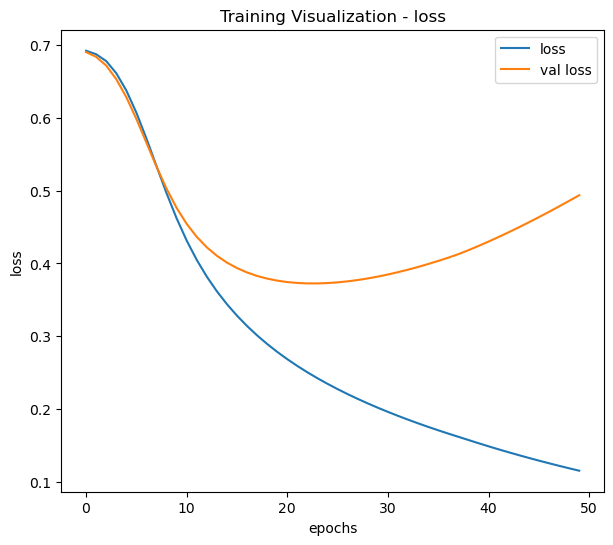

In [26]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training Visualization - loss")
plt.legend(loc = 'best')
plt.show()

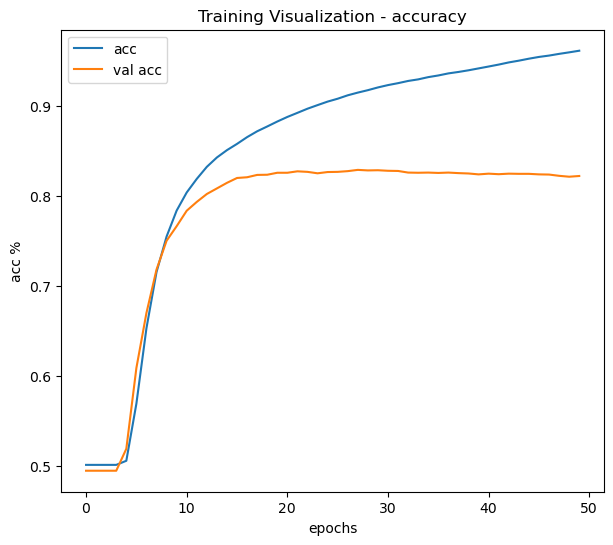

In [27]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Training Visualization - accuracy")
plt.legend(loc = 'best')
plt.show()

### Retrieve the trained word embeddings and save them to disk

- Now, retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape ```(vocab_size, embedding_dimension)```.

- Obtain the (trained) weights from the model using ```get_layer()``` and ```get_weights()```. The ```get_vocabulary()``` function provides the vocabulary to build a metadata file with one token per line.

In [29]:
# Get trained embedding parameters-
embedding_weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [30]:
embedding_weights.shape, len(vocab)

((10000, 20), 10000)

In [31]:
vocab[1], vocab[10], vocab[1000]

('[UNK]', 'i', 'further')

In [32]:
# Save the trained weights to disk. To use the Embedding Projector, you will upload two files in
# tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words)-

out_v = io.open('vectors.tsv', 'w', encoding = 'utf-8')
out_m = io.open('metadata.tsv', 'w', encoding = 'utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        # skip 0, it's padding-
        continue
    vec = embedding_weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")

out_v.close()
out_m.close()

### Employ dimensionality reduction to visualize trained embeddings for given vocabulary

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, SpectralEmbedding, TSNE

In [34]:
# Use PCA for dimensionality reduction algo-
pca = PCA(n_components = 5)
pca.fit_transform(embedding_weights)

array([[-3.29560414e-03,  1.82281628e-01,  2.73801219e-02,
        -3.54530588e-02,  2.18862575e-02],
       [ 5.72926328e-02,  3.51927310e-01,  1.18203156e-01,
        -6.09469675e-02, -1.17633808e-02],
       [-5.97197488e-02,  4.80466604e-01,  1.64874300e-01,
        -7.44425505e-02,  6.25384599e-03],
       ...,
       [-4.97933090e-01, -1.03422329e-01, -1.24024209e-02,
        -1.03295390e-02, -2.82712672e-02],
       [-7.34530747e-01, -9.28856200e-04, -2.80500837e-02,
         5.35070673e-02, -1.68302413e-02],
       [-1.68403506e+00, -3.60864103e-02,  1.71185862e-02,
         8.86139867e-04,  5.89587539e-03]], dtype=float32)

In [35]:
pca_variance = pca.explained_variance_

In [36]:
pca_variance

array([1.0803710e+00, 3.4943498e-03, 1.0808447e-03, 8.8703778e-04,
       8.7364973e-04], dtype=float32)

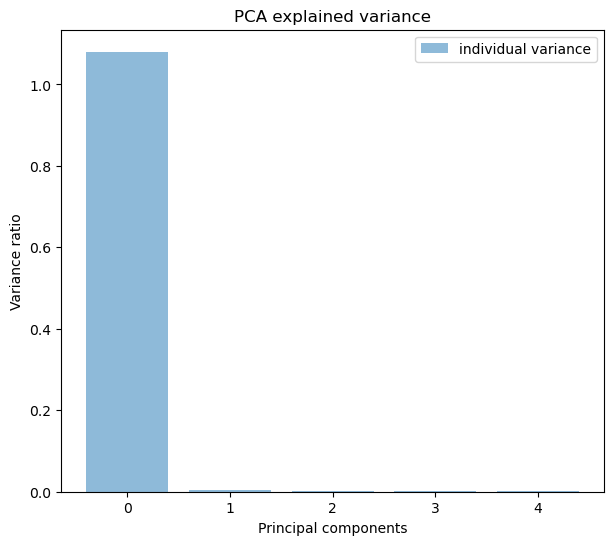

In [37]:
# Explained variance as visualization-
plt.figure(figsize = (7, 6))
plt.bar(
    range(5), pca_variance,
    alpha = 0.5, align = 'center',
    label = 'individual variance'
)
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.title("PCA explained variance")
plt.show()

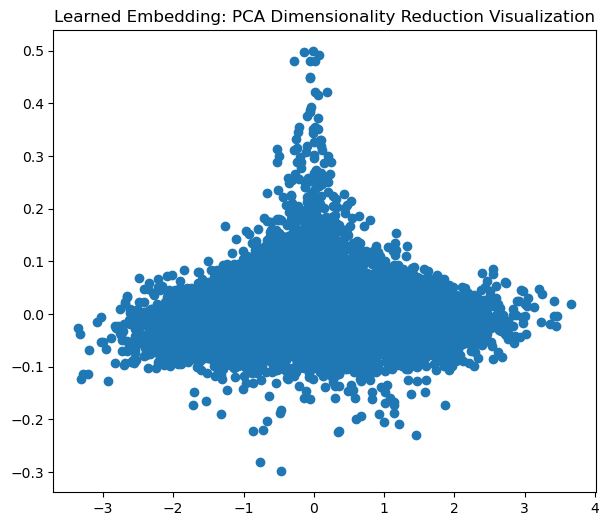

In [38]:
embeddings_pca = pca.transform(embedding_weights)

plt.figure(figsize = (7, 6))
plt.scatter(
    embeddings_pca[:, 0], embeddings_pca[:, 1],
    # c = m_data['class']
)
plt.title("Learned Embedding: PCA Dimensionality Reduction Visualization")
plt.show()

##### Note: PCA cannot capture the dimensionality reduction. Maybe the underlying data has no linear relationship?

In [39]:
# Use Isomap for dimensionality reduction-
isomap_model = Isomap(n_components = 3)
embeddings_isomap = isomap_model.fit_transform(embedding_weights)

In [40]:
embeddings_isomap.shape

(10000, 3)

In [ ]:
# Visualize latent space for latent vector-
fig = px.scatter_3d(
    x = embeddings_isomap[:, 0], y = embeddings_isomap[:, 1],
    z = embeddings_isomap[:, 2],
    # color = y
    )
fig.show()

In [42]:
# Use Spectral Embedding algo-
spectral_model = SpectralEmbedding(n_components = 3, affinity = 'nearest_neighbors')
embeddings_spectral = spectral_model.fit_transform(embedding_weights)

In [ ]:
# Visualize latent space for latent vector-
fig = px.scatter_3d(
    x = embeddings_spectral[:, 0], y = embeddings_spectral[:, 1],
    z = embeddings_spectral[:, 2],
    # color = y
    )
fig.show()

In [44]:
# Use t-SNE algo-
embeddings_tsne = TSNE(
    n_components = 3, learning_rate = 'auto',
    init = 'random', perplexity = 10
).fit_transform(embedding_weights)

In [ ]:
# Visualize latent space for latent vector-
fig = px.scatter_3d(
    x = embeddings_tsne[:, 0], y = embeddings_tsne[:, 1],
    z = embeddings_tsne[:, 2],
    # color = y
    )
fig.show()

### Next Steps

This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

- To train word embeddings using Word2Vec algorithm, try the [Word2Vec](https://www.tensorflow.org/tutorials/text/word2vec) tutorial.

- To learn more about advanced text processing, read the [Transformer model for language understanding](https://www.tensorflow.org/text/tutorials/transformer).